# Fully connected feedforward network implementing a loss mask

In [ ]:
import torchmetrics.classification
from torch import cuda

assert cuda.is_available()
assert cuda.device_count() > 0

In [ ]:
print(cuda.get_device_name(cuda.current_device()))


NVIDIA GeForce RTX 3060 Ti


In [ ]:
import torch
import torch.nn as nn

In [ ]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

### Load the Dataset

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
)

driams.loading_type = "memory"

driams

Loading Spectra into Memory:   0%|          | 0/55780 [00:00<?, ?it/s]

Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
Number resistant:,1068,13366,8578,21966,628,618,4223,7383,2338,3470,8659,5855,9338,310,4381,2874,7405,427,5468,2303,1326,3620,3481,7560,4217,5194,570,1271,1205,5537,12431,7616,486,580,244,3534,1707,227
Number susceptible:,20941,24992,4194,4905,456,457,5813,31567,4382,24566,28464,8368,36822,1262,9841,15784,24590,21740,9044,10184,4803,8498,22662,31717,17989,27228,4656,3603,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
Number data points:,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,37123,14223,46160,1572,14222,18658,31995,22167,14512,12487,6129,12118,26143,39277,22206,32422,5226,4874,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


### Model

In [ ]:
from multimodal_amr.models.modules import ResMLP


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.first = nn.Linear(18000 ,1024)
        self.res_mlp = ResMLP(
            n_layers= 5,
            dim= 1024,
            output_dim= len(driams.selected_antibiotics),
            p_dropout=0.2,
        )
        
    def forward(self, x):

        h_ = self.first(x)
        h_ = self.res_mlp(h_)
        
        output = torch.sigmoid(h_)

        return output


In [ ]:
len(driams.label_stats.columns)

38

In [ ]:
model = Model()
model.to(DEVICE)

Model(
  (first): Linear(in_features=18000, out_features=1024, bias=True)
  (res_mlp): ResMLP(
    (net): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
gen = torch.Generator()

batch_size = 128

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator=gen.manual_seed(SEED))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from tqdm.auto import tqdm
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []

criterion = nn.BCELoss()

class_weights_negative = torch.tensor((1 - (driams.label_stats.loc["negative"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)
class_weights_positive = torch.tensor((1 - (driams.label_stats.loc["positive"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)

criterion = MaskedBCE(class_weights_positive= class_weights_negative, class_weights_negative= class_weights_negative)

for epoch in tqdm(range(30)):
    overall_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()

        # output, mean, log_var = model(x)
        output = model(x)

        #loss = loss_function(y, output, mean, log_var)
        loss = criterion(output, y)
        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/30 [00:00<?, ?it/s]

	Average Loss: 0.000263 	Learning rate: 0.001000
	Average Loss: 0.000220 	Learning rate: 0.001000
	Average Loss: 0.000205 	Learning rate: 0.001000
	Average Loss: 0.000196 	Learning rate: 0.001000
	Average Loss: 0.000186 	Learning rate: 0.001000
	Average Loss: 0.000178 	Learning rate: 0.001000
	Average Loss: 0.000169 	Learning rate: 0.001000
	Average Loss: 0.000162 	Learning rate: 0.001000
	Average Loss: 0.000155 	Learning rate: 0.001000
	Average Loss: 0.000150 	Learning rate: 0.000500
	Average Loss: 0.000132 	Learning rate: 0.000500
	Average Loss: 0.000125 	Learning rate: 0.000500
	Average Loss: 0.000120 	Learning rate: 0.000500
	Average Loss: 0.000115 	Learning rate: 0.000500
	Average Loss: 0.000111 	Learning rate: 0.000500
	Average Loss: 0.000107 	Learning rate: 0.000500
	Average Loss: 0.000105 	Learning rate: 0.000500
	Average Loss: 0.000101 	Learning rate: 0.000500
	Average Loss: 0.000097 	Learning rate: 0.000500
	Average Loss: 0.000094 	Learning rate: 0.000250
	Average Loss: 0.000

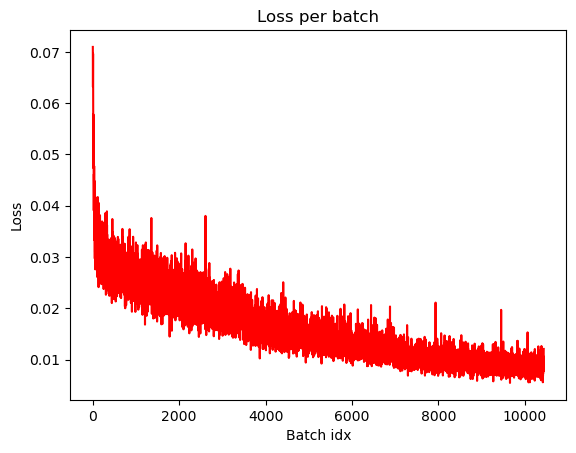

In [ ]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.show()

In [ ]:
model.eval()

Model(
  (first): Linear(in_features=18000, out_features=1024, bias=True)
  (res_mlp): ResMLP(
    (net): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, './model.pt')